In [6]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, date
from matplotlib import pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_parquet('data/ecom_sample_clean.parquet')

In [13]:
df.set_index(['Date','StockCode','Country']).sample(10)

,,,Description,Quantity,revenue,UnitPrice
Date,StockCode,Country,,,,
2010-12-06,85066,United Kingdom,CREAM SWEETHEART MINI CHEST,2,50.98,25.49
2011-01-24,22751,United Kingdom,FELTCRAFT PRINCESS OLIVIA DOLL,1,3.75,3.75
2011-10-28,21240,United Kingdom,BLUE POLKADOT CUP,2,3.26,1.63
2011-04-20,21314,United Kingdom,SMALL GLASS HEART TRINKET POT,8,16.80,2.10
2011-01-28,21041,United Kingdom,RED RETROSPOT OVEN GLOVE DOUBLE,5,14.75,2.95
2011-05-27,22424,United Kingdom,ENAMEL BREAD BIN CREAM,5,63.75,12.75
2011-09-12,22679,United Kingdom,FRENCH BLUE METAL DOOR SIGN 4,1,2.46,2.46
2011-04-17,23049,United Kingdom,RECYCLED ACAPULCO MAT RED,2,16.50,8.25
2011-11-24,23390,United Kingdom,DOLLY GIRL MINI BACKPACK,1,4.15,4.15


<Axes: title={'center': 'number of items sold and revenue over time'}, xlabel='Date'>

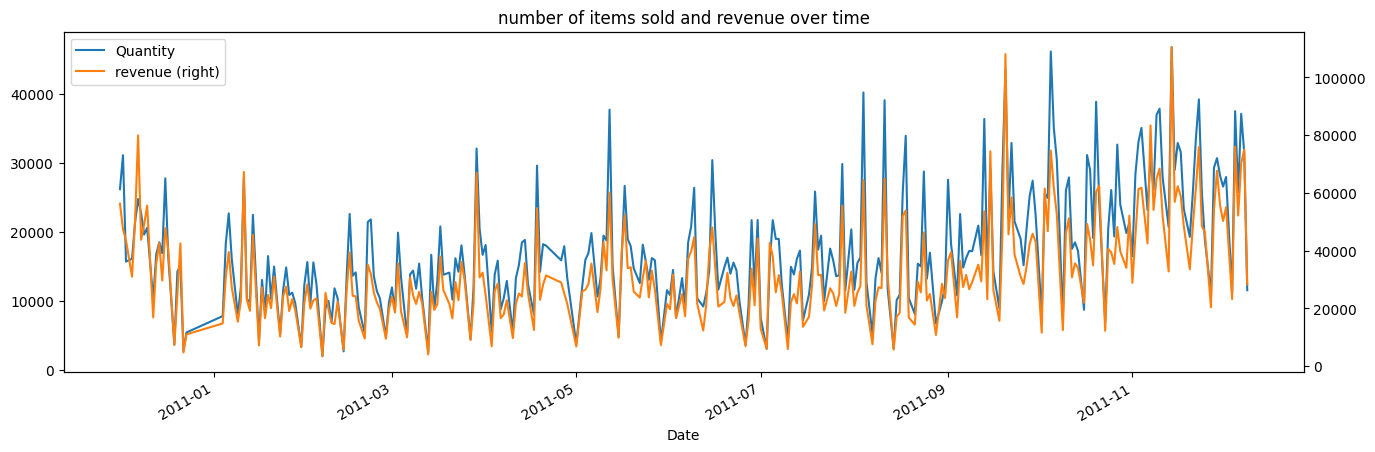

In [14]:
df.groupby('Date').agg(
    {'Quantity': 'sum', 'revenue': 'sum'}
).plot(
    title='number of items sold and revenue over time', 
    secondary_y='revenue',
    figsize=(16, 5)
)

In [15]:
df_mdl = df[
    (df.groupby('StockCode').UnitPrice.transform('std') > 0)
]
del df

In [16]:
len(df_mdl)


294575

## Price Elasticity

In [17]:
df_mdl = df_mdl.assign(
    LnP = np.log(df_mdl['UnitPrice']),
    LnQ = np.log(df_mdl['Quantity']),
)

In [18]:
df_mdl[['LnP', 'LnQ']].cov()

,LnP,LnQ
LnP,0.90431,-0.526940
LnQ,-0.52694,1.816541


In [19]:
import statsmodels.api as sm # get full stats on regressions

def binned_ols(df, x, y, n_bins, plot=True, plot_title='', plot_ax=None, **plt_kwargs):

    x_bin = x + '_bin'
    df[x_bin] = pd.qcut(df[x], n_bins)

    tmp = df.groupby(x_bin).agg({
        x: 'mean',
        y: 'mean'
    })

    if plot:
        tmp.plot(
            x=x, 
            y=y,
            figsize=(18, 6),
            title=plot_title,
            ax=plot_ax,
            **plt_kwargs
        )
    
    del df[x_bin]
    mdl = sm.OLS(tmp[y], sm.add_constant(tmp[x]))
    res = mdl.fit()
    return res

"Naive" elasticity estimated to be -0.6064226294934306


/var/folders/pr/9_2s18ld0_d38x14xrf468fh0000gn/T/ipykernel_59105/2298015777.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby(x_bin).agg({
/Users/harveyjiang/.pyenv/versions/3.10.7/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    LnQ   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     50.31
Date:                Thu, 16 May 2024   Prob (F-statistic):           8.13e-06
Time:                        22:33:14   Log-Likelihood:                -2.4962
No. Observations:                  15   AIC:                             8.992
Df Residuals:                      13   BIC:                             10.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3614      0.102     23.070      0.000       2.140       2.583
LnP           -0.6064      0.085     -7.093      0.000      -0.791      -0.422
==============================================================================
Omnibus:                        6.769   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                3.768
Skew:                           0.710   Prob(JB):                        0.152
Kurtosis:                       5.002   Cond. No.                         2.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

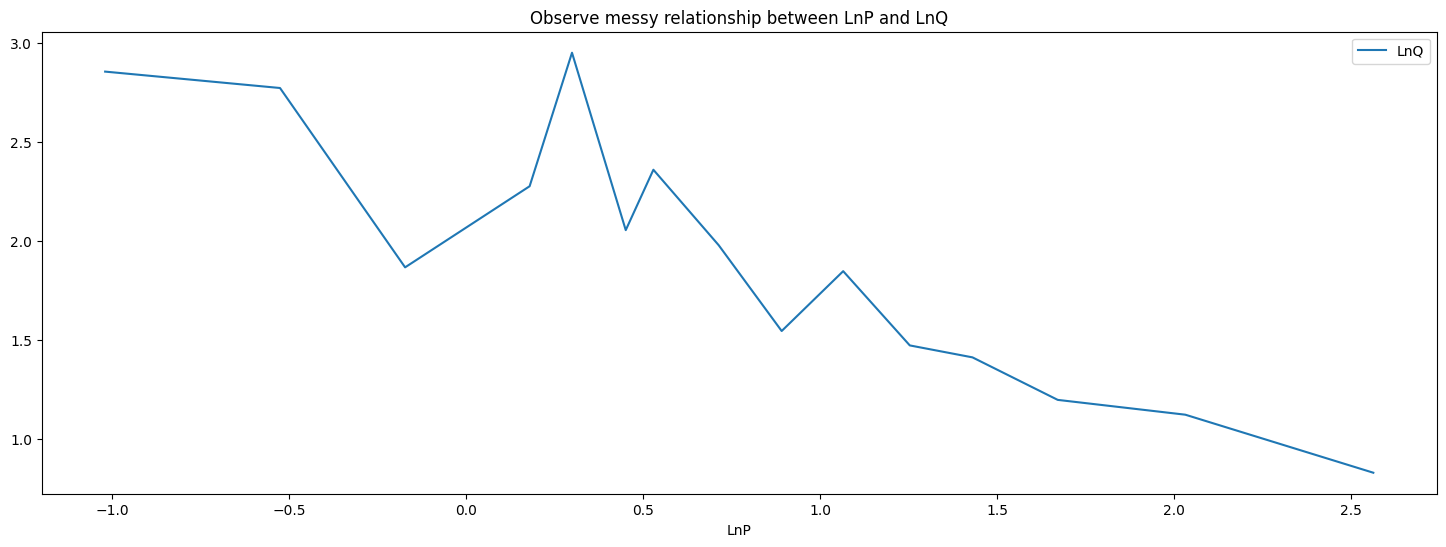

In [20]:
ols_fit = binned_ols(
    df_mdl,
    x='LnP',
    y='LnQ',
    n_bins=15,
    plot_title='Observe messy relationship between LnP and LnQ'
)

print(f'"Naive" elasticity estimated to be {ols_fit.params["LnP"]}')
ols_fit.summary()

In [21]:
import sklearn.preprocessing
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
feature_generator_basic = ColumnTransformer(
    [
        ('StockCode', OneHotEncoder(), ['StockCode']),
        ('Date', OneHotEncoder(), ['Date']),
        ('Country', OneHotEncoder(), ['Country']),
        ('LnP', 'passthrough', ['LnP']),
    ], remainder='drop'
)

mdl_basic = Pipeline([
    ('feat_proc', feature_generator_basic),
    ('reg', linear_model.PoissonRegressor(
        alpha=1e-6,  # l2 penalty strength; manually selected value for minimum interference on LnP-coef (elasticity)
        fit_intercept=False, # no need, since we have OneHot encodings without drop
        max_iter=100_000, 
    )),
], verbose=True)

mdl_basic_ols = Pipeline([
    ('feat_proc', feature_generator_basic),
    ('reg', linear_model.Ridge(
        alpha=1e-20,  # l2 penalty strength, "very small"
        fit_intercept=False, 
        max_iter=100_000, 
    )),
], verbose=True)

In [23]:
mdl_basic.fit(
    df_mdl[['LnP', 'StockCode', 'Date', 'Country']], 
    df_mdl['Quantity'] # Poisson regression has log-link, so LnQ is implicit in loss function
)

[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing reg, total=  10.1s


Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('StockCode', OneHotEncoder(),
                                                  ['StockCode']),
                                                 ('Date', OneHotEncoder(),
                                                  ['Date']),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('LnP', 'passthrough',
                                                  ['LnP'])])),
                ('reg',
                 PoissonRegressor(alpha=1e-06, fit_intercept=False,
                                  max_iter=100000))],
         verbose=True)

In [24]:
mdl_basic_ols.fit(
    df_mdl[['LnP', 'StockCode', 'Date', 'Country']], 
    df_mdl['LnQ'] # log-normal
)

[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.2s


Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('StockCode', OneHotEncoder(),
                                                  ['StockCode']),
                                                 ('Date', OneHotEncoder(),
                                                  ['Date']),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('LnP', 'passthrough',
                                                  ['LnP'])])),
                ('reg',
                 Ridge(alpha=1e-20, fit_intercept=False, max_iter=100000))],
         verbose=True)

In [26]:
print('"Econometrically" estimated elasticity with unit-, time-, and market- controls, using Poisson loss (coef on LnP):')
coef = pd.DataFrame({
    'feat': mdl_basic['feat_proc'].get_feature_names_out(),
    'coef': mdl_basic['reg'].coef_
})
coef.iloc[-1]

"Econometrically" estimated elasticity with unit-, time-, and market- controls, using Poisson loss (coef on LnP):


feat    LnP__LnP
coef   -2.875823
Name: 3708, dtype: object

/var/folders/pr/9_2s18ld0_d38x14xrf468fh0000gn/T/ipykernel_59105/673755494.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(pos_normal), label='lognormal', ax=ax[0])
/var/folders/pr/9_2s18ld0_d38x14xrf468fh0000gn/T/ipykernel_59105/673755494.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.di

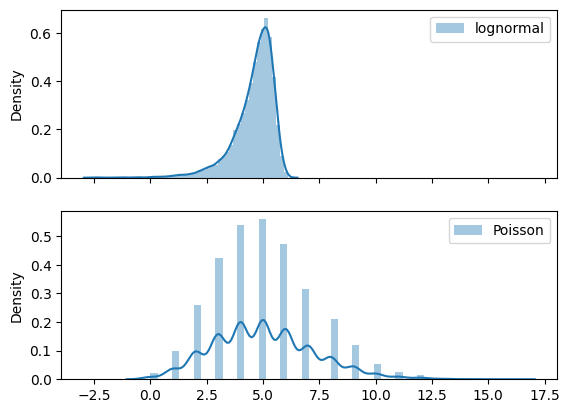

In [27]:
f, ax = plt.subplots(2, 1, sharex=True)
pos_normal = np.random.normal(loc=100, scale=100, size=12_000)
pos_normal = pos_normal[pos_normal > 0]
sns.distplot(np.log(pos_normal), label='lognormal', ax=ax[0])
sns.distplot(np.random.poisson(lam=5, size=10_000), label='Poisson', ax=ax[1])

ax[0].legend()
ax[1].legend()

<Axes: title={'center': 'Date fixed effects track (avg) sales, but not perfectly: Deviation is explained by large effect of individual items [unit-normalized data]'}, xlabel='Date'>

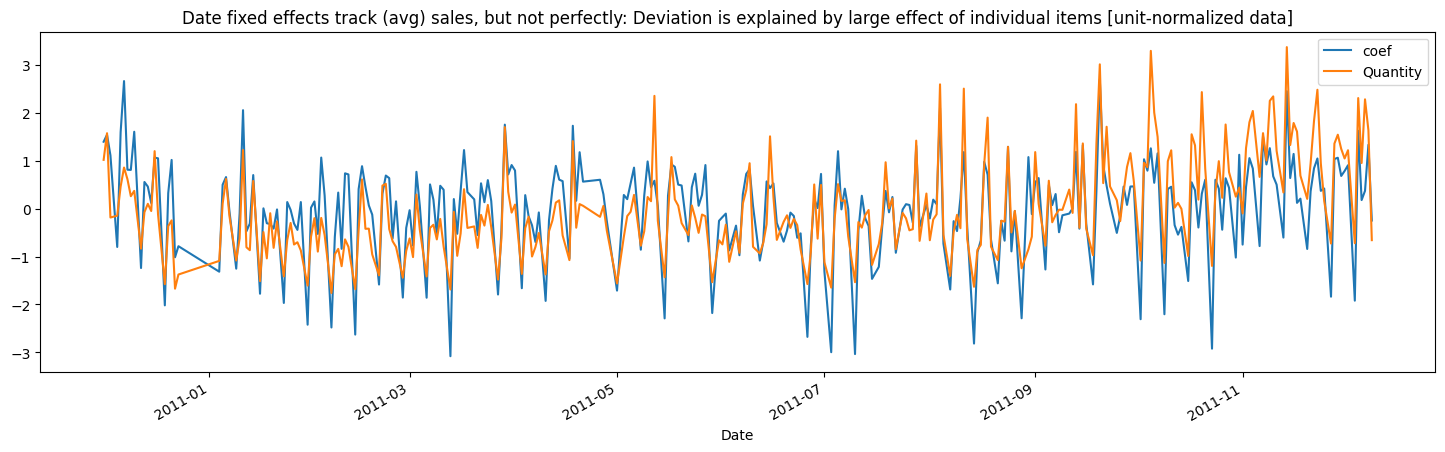

In [28]:
(
    pd.concat(
        [
            coef[coef.feat.str.startswith('Date')].reset_index(drop=True),
            df_mdl.groupby('Date').Quantity.sum().reset_index()
        ], 
        axis=1
    )
    .set_index(['Date'])
    .drop(columns=['feat'])
    .pipe(
        lambda d: (d - d.mean()) / d.std()
    )
).plot(
    figsize=(18, 5),
    title='Date fixed effects track (avg) sales, but not perfectly: Deviation is explained by large effect of individual items [unit-normalized data]'
)

In [29]:
df_mdl['dLnP'] = np.log(df_mdl.UnitPrice) - np.log(df_mdl.groupby('StockCode').UnitPrice.transform('mean'))
df_mdl['dLnQ'] = np.log(df_mdl.Quantity) - np.log(df_mdl.groupby('StockCode').Quantity.transform('mean')) 

In [30]:
df_mdl[['dLnP', 'dLnQ']].cov()

,dLnP,dLnQ
dLnP,0.069442,-0.122739
dLnQ,-0.122739,1.274948


In [31]:
df_mdl = df_mdl.assign(
    month = lambda d: d.Date.dt.month,
    DoM =   lambda d: d.Date.dt.day,
    DoW =   lambda d: d.Date.dt.weekday,
    stock_age_days = lambda d: 
        (d.Date - d.groupby('StockCode').Date.transform('min')).dt.days,
    sku_avg_p = lambda d: 
        d.groupby('StockCode').UnitPrice.transform('median')
)

## Train auxiliary models for DML

In [32]:
from sklearn.ensemble import RandomForestRegressor

feature_generator_full = ColumnTransformer(
    [
        # do NOT include to reduce overfit (price is sku-level-demeaned anyway): 
        # ('StockCode', OneHotEncoder(), ['StockCode']), 
        ('Date', OneHotEncoder(), ['Date']),
        ('Description', CountVectorizer(min_df=0.0025, ngram_range=(1, 3)), 'Description'),
        ('Country', OneHotEncoder(), ['Country']),
        ('numeric_feats', StandardScaler(), ['month', 'DoM', 'DoW', 'stock_age_days', 'sku_avg_p']),
    ], remainder='drop'
)

In [33]:
model_y = Pipeline([
    ('feat_proc', feature_generator_full),
    ('model_y', RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1, verbose=0)) 
    # n_samples_leaf/n_estimators is set to reduce model (file) size and runtime
    # larger models yield prettier plots.
])
model_t = Pipeline([
    ('feat_proc', feature_generator_full),
    ('model_t', RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1, verbose=0))
])

In [37]:
import joblib

# try: # load existing models, if possible
#     model_y = joblib.load('models/step1_model_y.joblib')
#     model_t = joblib.load('models/step1_model_t.joblib')
# except:
print('No pre-existing models found, fitting aux models for y and t')
model_y.fit(df_mdl, df_mdl.dLnQ)
model_t.fit(df_mdl, df_mdl.dLnP)

joblib.dump(model_y, 'models/step1_model_y.joblib', compress=True)
joblib.dump(model_t, 'models/step1_model_t.joblib', compress=True)

No pre-existing models found, fitting aux models for y and t


['models/step1_model_t.joblib']

In [38]:
q_hat = model_y.predict(df_mdl)
p_hat = model_t.predict(df_mdl)

In [39]:
df_mdl = df_mdl.assign(
    dLnP_res = df_mdl['dLnP'] - p_hat,
    dLnQ_res = df_mdl['dLnQ'] - q_hat,
)

/var/folders/pr/9_2s18ld0_d38x14xrf468fh0000gn/T/ipykernel_59105/2298015777.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby(x_bin).agg({
/var/folders/pr/9_2s18ld0_d38x14xrf468fh0000gn/T/ipykernel_59105/2298015777.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby(x_bin).agg({


"Average" elasticity estimated using DML to be -1.818
Note that this is close to our econometric contols - some difference comes from the different distribution assumptions (Poisson vs. log-normal)


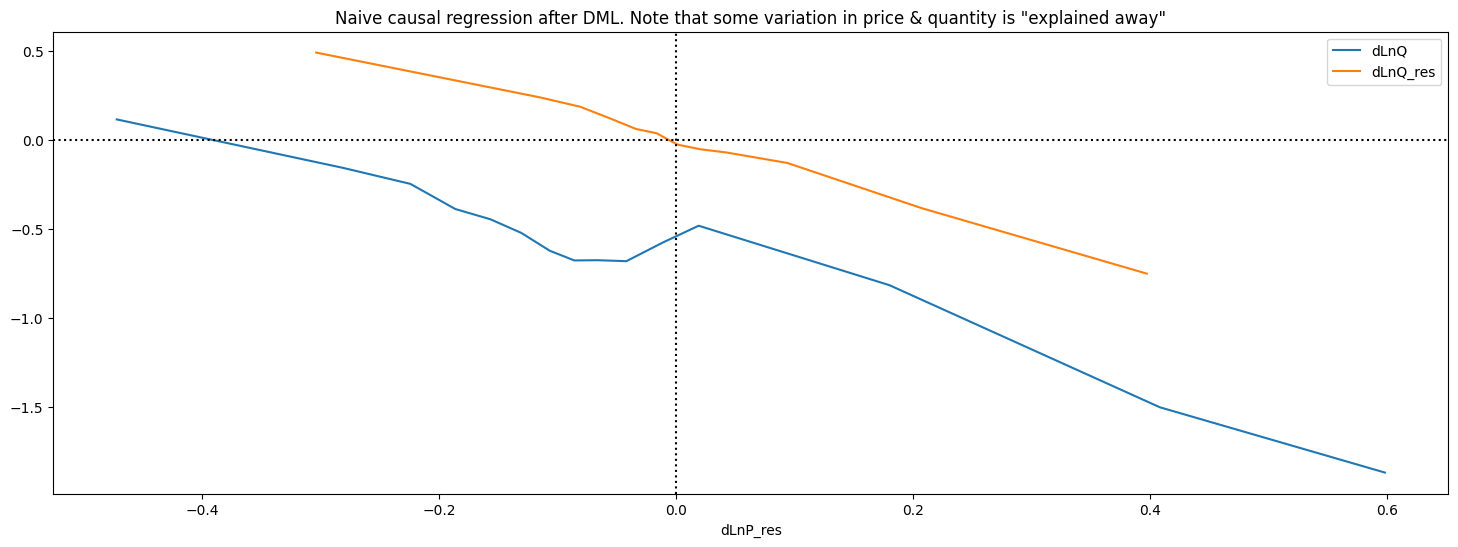

In [40]:
old_fit = binned_ols(
    df_mdl,
    x='dLnP',
    y='dLnQ',
    n_bins=15,
)

old_fit = binned_ols(
    df_mdl,
    x='dLnP_res',
    y='dLnQ_res',
    n_bins=15,
    plot_title='Naive causal regression after DML. Note that some variation in price & quantity is "explained away"',
    plot_ax=plt.gca()
)

plt.gca().axvline(0, color='k', linestyle=':')
plt.gca().axhline(0, color='k', linestyle=':')


print(
    f'"Average" elasticity estimated using DML to be {old_fit.params["dLnP_res"]:.3f}\n'
    'Note that this is close to our econometric contols - some difference comes from the different distribution '
    'assumptions (Poisson vs. log-normal)'
)

"Average" elasticity estimated using DML (now supposedly valid estimate!) to be -1.818
Note that this is close to our econometric contols - some difference comes from the different distribution assumptions (Poisson vs. log-normal)


/var/folders/pr/9_2s18ld0_d38x14xrf468fh0000gn/T/ipykernel_59105/2298015777.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby(x_bin).agg({
/var/folders/pr/9_2s18ld0_d38x14xrf468fh0000gn/T/ipykernel_59105/2298015777.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby(x_bin).agg({
/var/folders/pr/9_2s18ld0_d38x14xrf468fh0000gn/T/ipykernel_59105/2298015777.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

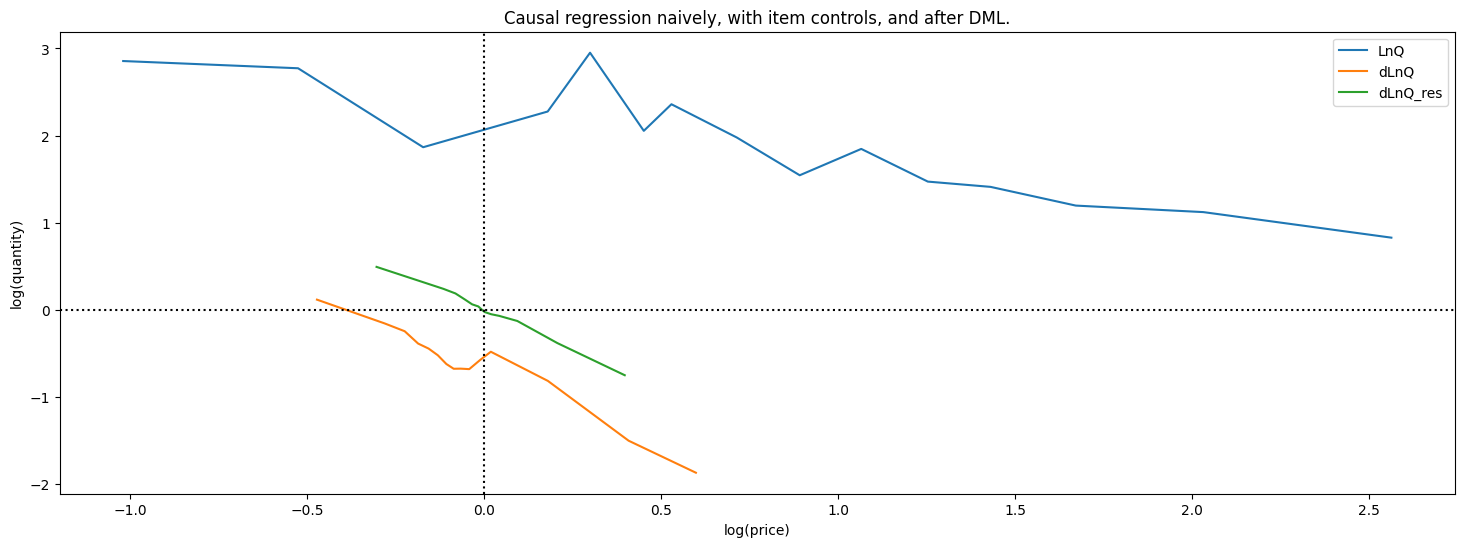

In [41]:
old_fit = binned_ols(
    df_mdl,
    x='LnP',
    y='LnQ',
    n_bins=15,
)

old_fit = binned_ols(
    df_mdl,
    x='dLnP',
    y='dLnQ',
    n_bins=15,
    plot_ax=plt.gca(),
)

old_fit = binned_ols(
    df_mdl,
    x='dLnP_res',
    y='dLnQ_res',
    n_bins=15,
    plot_title='Causal regression naively, with item controls, and after DML.',
    plot_ax=plt.gca()
)
plt.gca().set(
    xlabel='log(price)',
    ylabel='log(quantity)',    
)

plt.gca().axvline(0, color='k', linestyle=':')
plt.gca().axhline(0, color='k', linestyle=':')


print(
    f'"Average" elasticity estimated using DML (now supposedly valid estimate!) to be {old_fit.params["dLnP_res"]:.3f}\n'
    'Note that this is close to our econometric contols - some difference comes from the different distribution '
    'assumptions (Poisson vs. log-normal)'
)